In [1]:
from netCDF4 import Dataset
import collections
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from pathlib import Path
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd
import glob
import geopandas as gpd
import shapefile as shp 

In [2]:
#fh = Dataset("adaptor.mars.internal-1655727168.606427-18601-13-6d9e5cb6-ff7f-4034-b7f3-b6019b39c9e6.nc",mode='r')
ds = xr.open_dataset("spatially_refined_ladakh.nc",decode_cf=True)
fh = ds
#fh = ds.where((ds.longitude <= 79.5) & (ds.latitude <= 34.5) , drop = True)
# print(fh)
#fh['tcwv'] = fh['tcwv'] *fh['tcwv'].scale_factor + fh['tcwv'].add_offset

#print(fh['tcwv'])


In [3]:
lons = np.array(fh.variables['longitude'][:])
lats = np.array(fh.variables['latitude'][:])
pwv = np.array(fh.variables['tcwv'][:])
time = np.array(fh.variables['time'][:])

print(lats)

[35.25 35.   34.75 34.5  34.25 34.   33.75 33.5  33.25 33.   32.75 32.5
 32.25 32.  ]


In [4]:
i=0
yearly_data = []
while(i<504):
    pwv_slice = fh['tcwv'][i:i+12]
    yearly_data.append(np.array(pwv_slice))

    i+=12
yearly_data = np.array(yearly_data)



To Save upto N minimum PWV locations for every year; Each minimum value is stored in a different file.

In [5]:
min_upto_val = 10
yearly_data_copy = yearly_data.copy()

for i in range(min_upto_val):
    min_arr =[]
    for year in range(42):
        np.set_printoptions(suppress=True)
        data = yearly_data_copy[year]
        min_val = np.nanmin(data)
        coord = np.unravel_index(np.nanargmin(data),data.shape)
        yearly_data_copy[year][coord[0]][coord[1]][coord[2]] = np.nan
        min_arr.append([year+1980,min_val,coord[0]+1,lats[coord[1]],lons[coord[2]]])
        

    np.savetxt('min_arr_'+str(i+1)+'.txt',min_arr,fmt='%d %f %d %f %f')

    

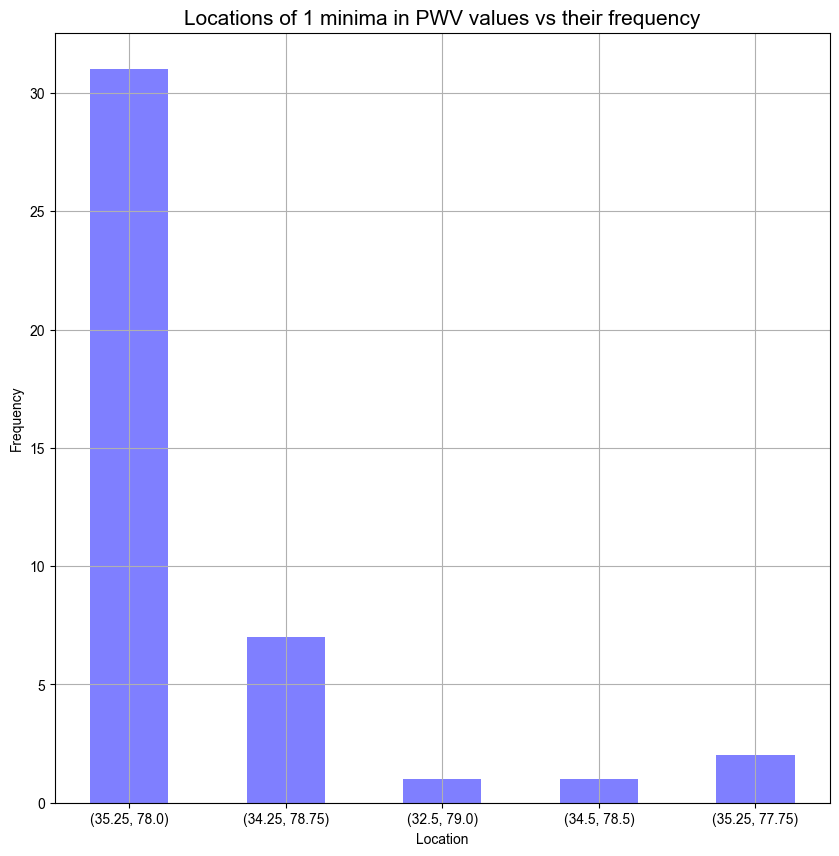

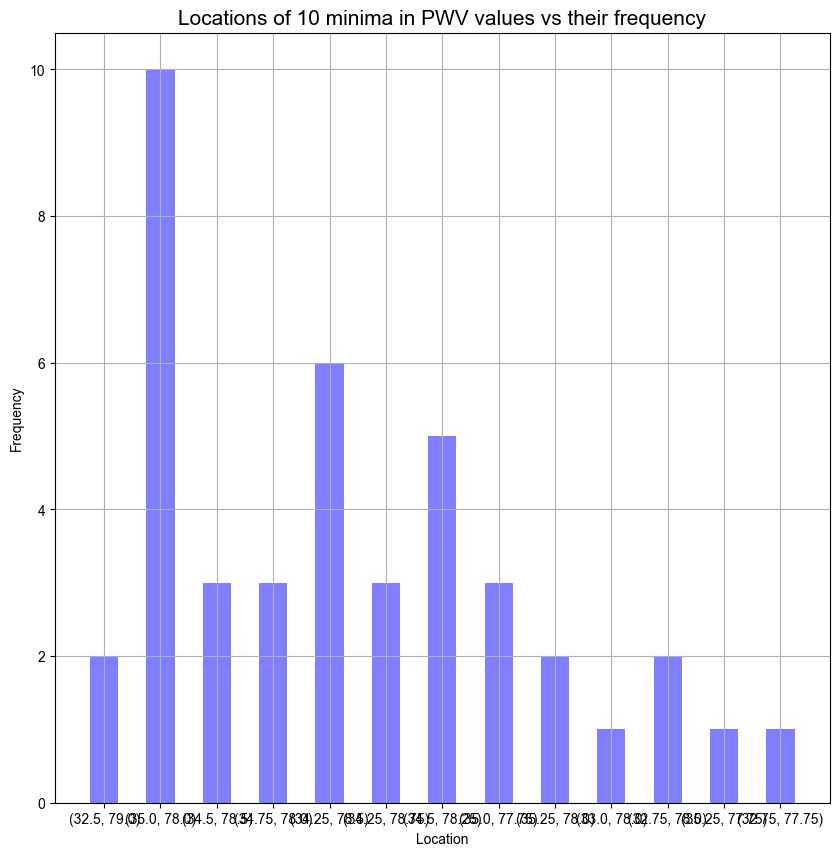

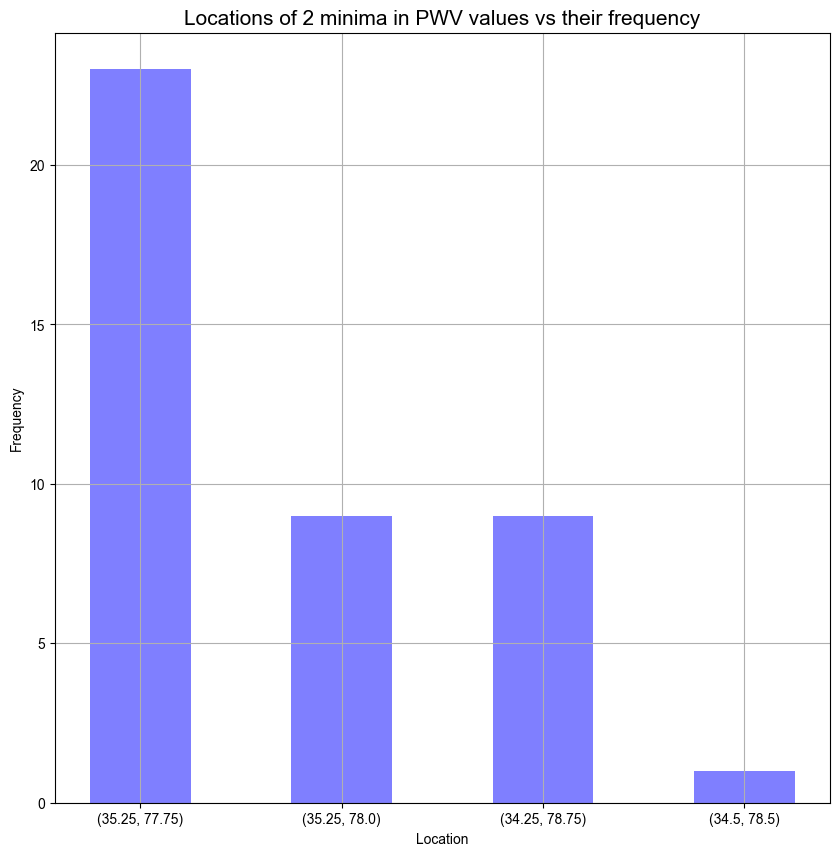

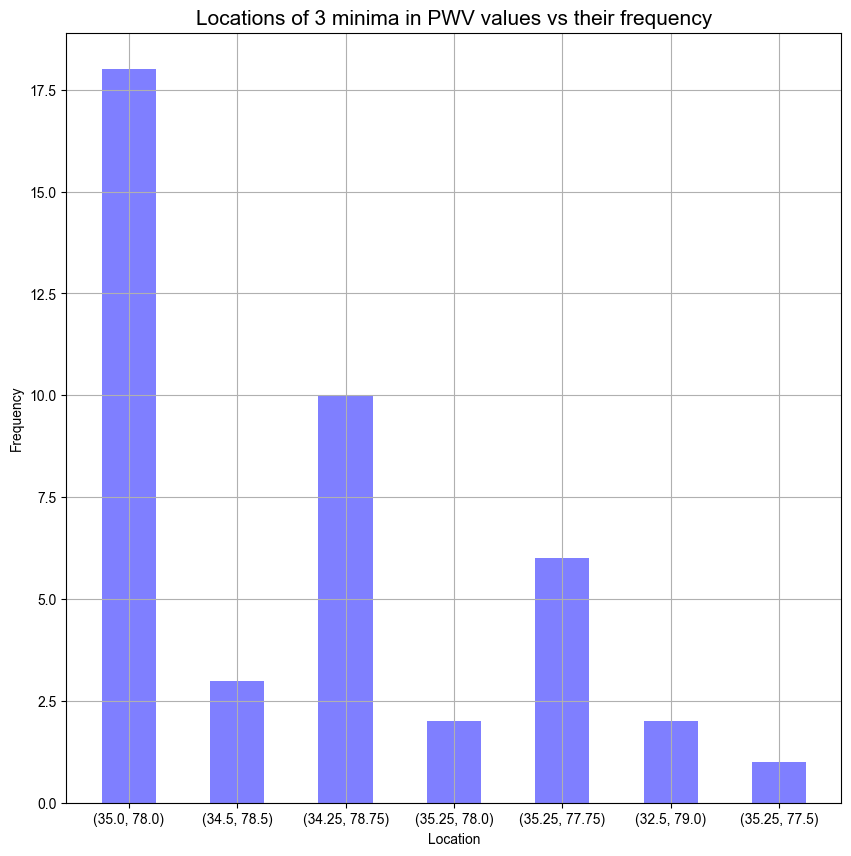

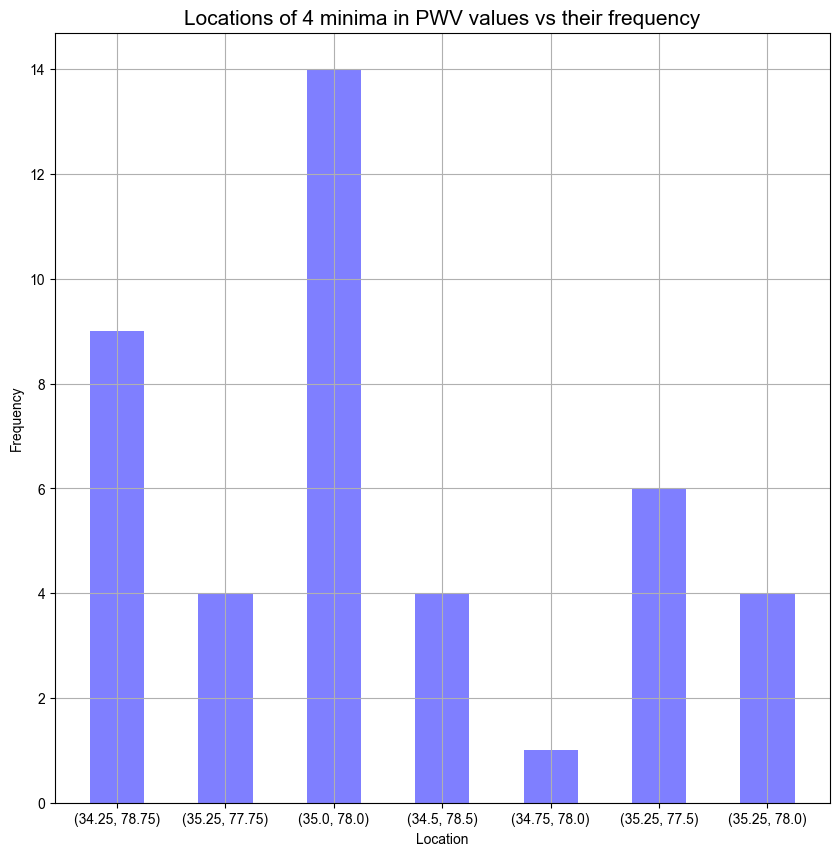

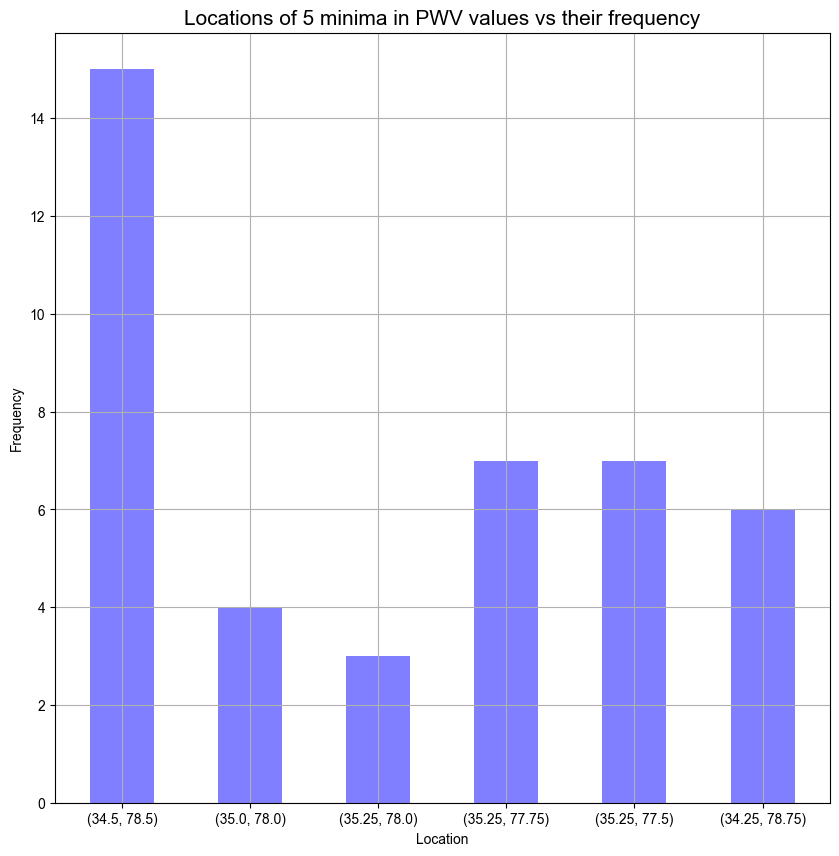

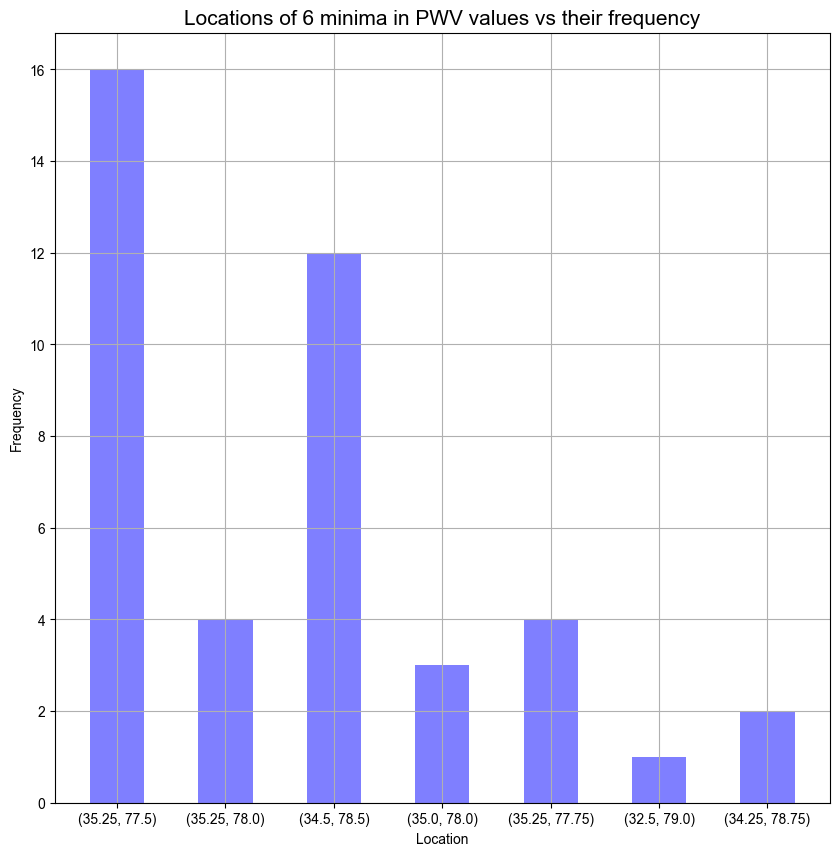

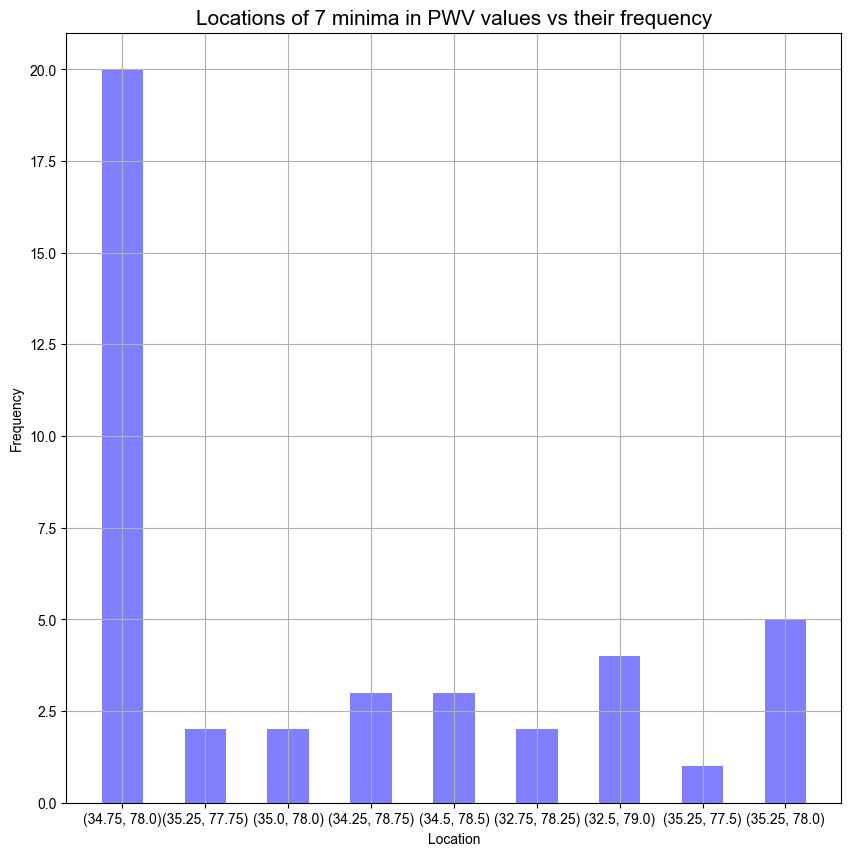

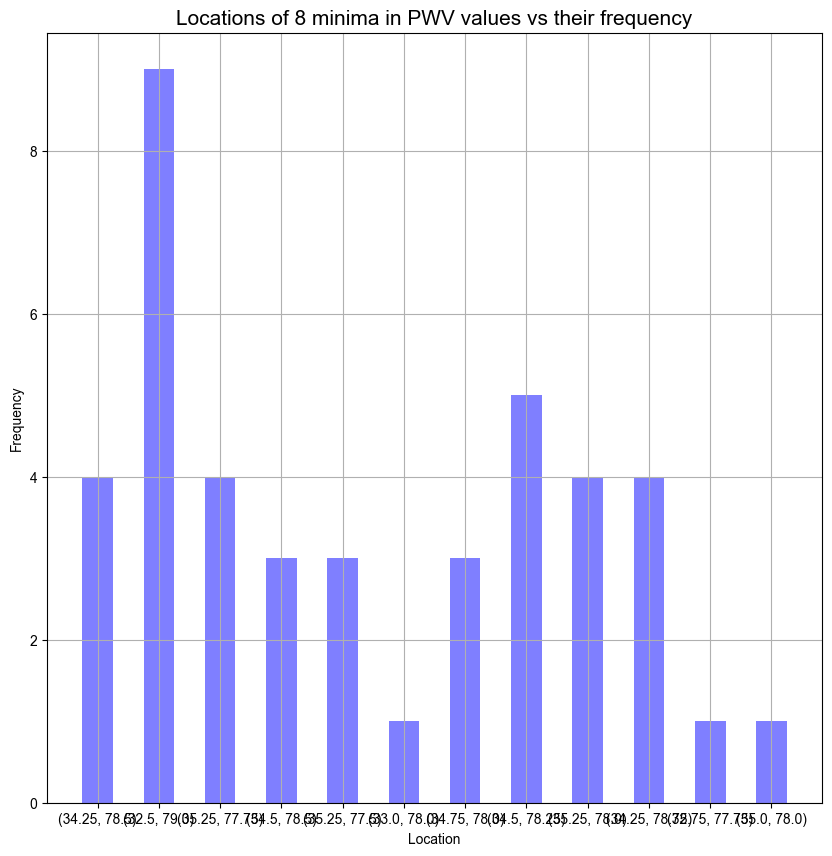

In [30]:
files=glob.glob("*.txt")
files = files[1:-1]

data_to_plot = []

for file in files:
    # if(d!=0):
    #     break

    # d+=1
    file_name = Path(file).stem
    file_number = file_name.split('_')[2]

    min_data = np.loadtxt(file)
    min_loc_data = min_data[:,3:5]
    counter = collections.Counter(map(tuple, min_loc_data))
    df = pd.Series(counter)
    plt.figure(figsize = (10,10))
    plt.bar(range(len(df)), df.values, align='center', width=0.5, color='blue', alpha=0.5, label='min_val',)
    plt.xticks(range(len(df)), df.index.values, size='medium')
    plt.xlabel('Location', fontsize=10)
    plt.ylabel('Frequency',fontsize = 10)
    plt.grid(True)
    plt.title('Locations of '+str(file_number)+' minima in PWV values vs their frequency',fontsize =15)
    #plt.savefig(file.replace('.txt','.png'))
    plt.show()



In [35]:

def plot_locations(file,c):
    fontdict={'fontsize': '15', 'fontweight' : '3', 'family' : 'serif', 'color' : '#000000', 'horizontalalignment' : 'center'}
    min_data = np.loadtxt(file)
    min_loc_data = min_data[:,3:5]
    counter = collections.Counter(map(tuple, min_loc_data))
    # loc_data = np.array(counter.most_common(10))
    # loc_coords = loc_data[:,0]
    # lat = np.array([x[0] for x in loc_coords])
    # lon = np.array([x[1] for x in loc_coords])
    # loc_freq = loc_data[:,1]
    # loc_freq = [float(i)*20 for i in loc_freq ] 

    plt.figure(figsize = (10,10))

    m = Basemap(
                llcrnrlat = 32,
                urcrnrlat = 36,
                llcrnrlon = 76,
                urcrnrlon = 80,
                resolution = 'c')
    m.drawcoastlines()

    m.drawparallels(np.arange(32,36,1),labels=[True,False,False,False])
    m.drawmeridians(np.arange(76,80,1),labels=[0,0,0,1])
    m.drawrivers(linewidth=0.5, color='blue')
    m.drawstates(linewidth=0.5, color='blue')
   
    
    # Extract the coordinates and frequencies separately
    loc_counts = counter.most_common(10)
    loc_coords, loc_freq = zip(*loc_counts)

    # Convert the coordinates to separate latitude and longitude arrays
    lat = np.array([coord[0] for coord in loc_coords])
    lon = np.array([coord[1] for coord in loc_coords])

    # Convert loc_freq to float and scale
    loc_freq = np.array(loc_freq, dtype=float) * 20

    # Now create loc_data as a structured array
    loc_data = np.array(list(zip(lat, lon, loc_freq)), dtype=[('Lat', float), ('Lon', float), ('Freq', float)])

    plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


    #c=loc_freq

    sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\IND_adm\IND_adm2.shp")
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]

        plt.plot(x,y,color='black',linewidth=1)
        plt.xlim(xmin = 76, xmax = 80)
        plt.ylim(ymin = 32, ymax = 36)
    plt.grid()
    plt.ylabel('Latitude (°N) ',fontdict = fontdict,labelpad=30)
    plt.xlabel('Longitude (°E)',fontdict = fontdict,labelpad=30)
    m.drawcoastlines()        
    m.drawstates()
    m.drawcountries()
    m.drawmapboundary(fill_color="#DDEEFF")
    plt.plot(79.0002,32.7908,  'o', color='red', markersize=10)
    plt.text(79.0002,32.7908,  'HANLE', fontsize=15)
    plt.title('Locations with minimum PWV: ' + str(c) +' minima', fontsize=20)
    plt.savefig(file.replace('.txt','.jpeg'))
    


['min_arr_1.txt', 'min_arr_10.txt', 'min_arr_2.txt', 'min_arr_3.txt', 'min_arr_4.txt', 'min_arr_5.txt', 'min_arr_6.txt', 'min_arr_7.txt', 'min_arr_8.txt']
1


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


10


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


2


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


3


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


4


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


5


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


6


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


7


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


8


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_18680\2194113963.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lon, lat, cmap='jet', marker='o', s=loc_freq, edgecolors='black')


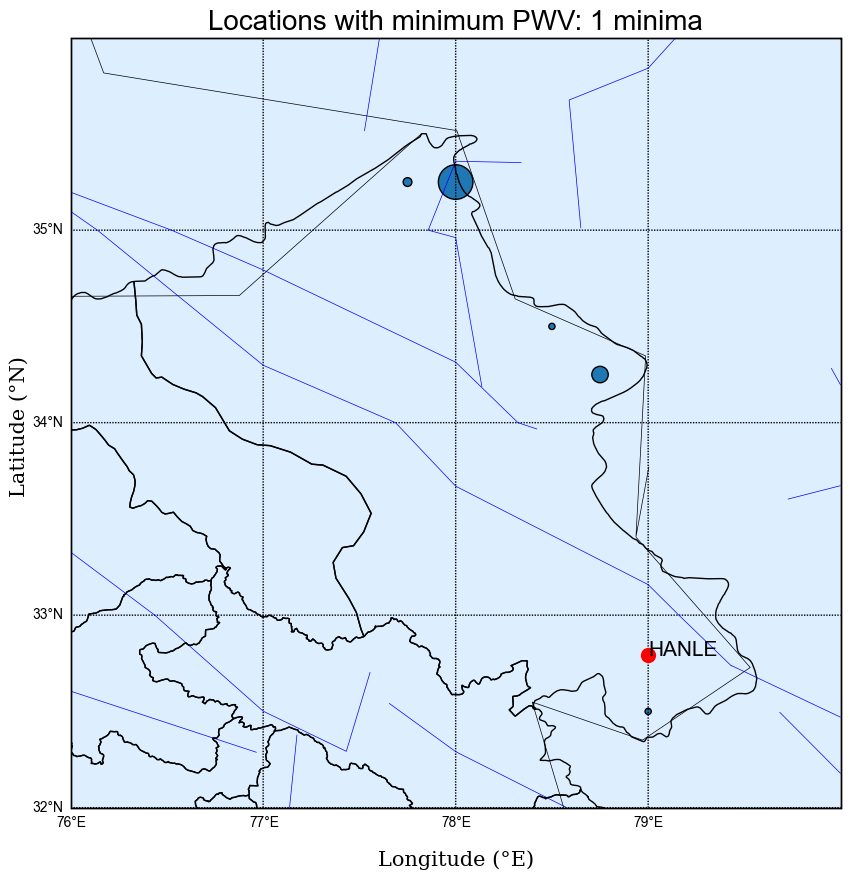

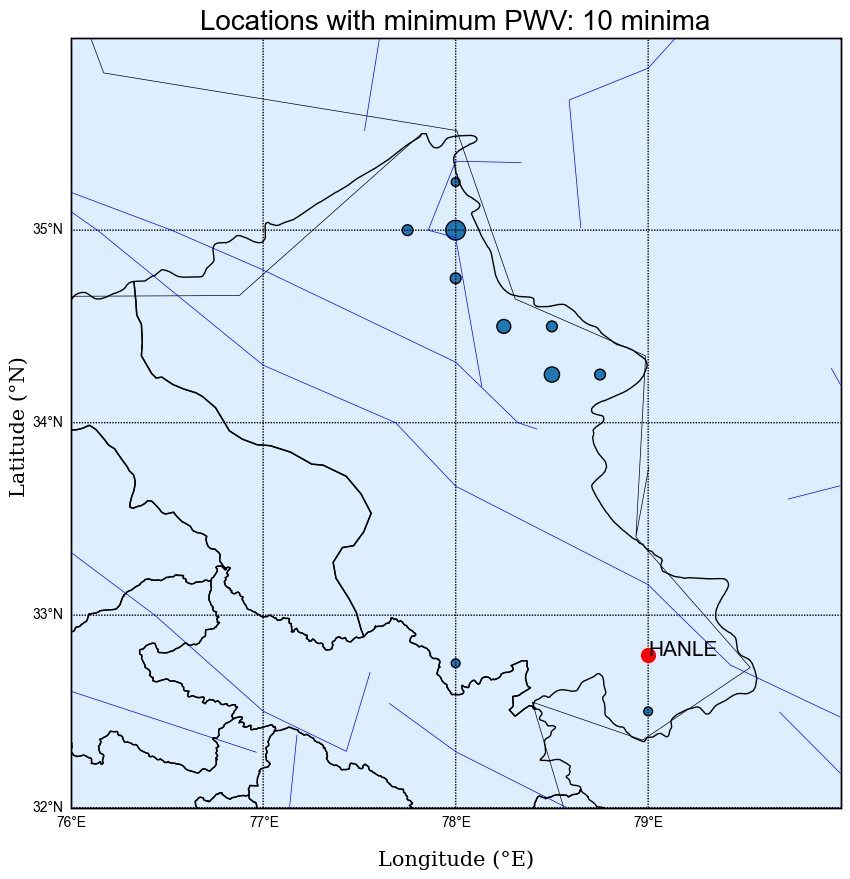

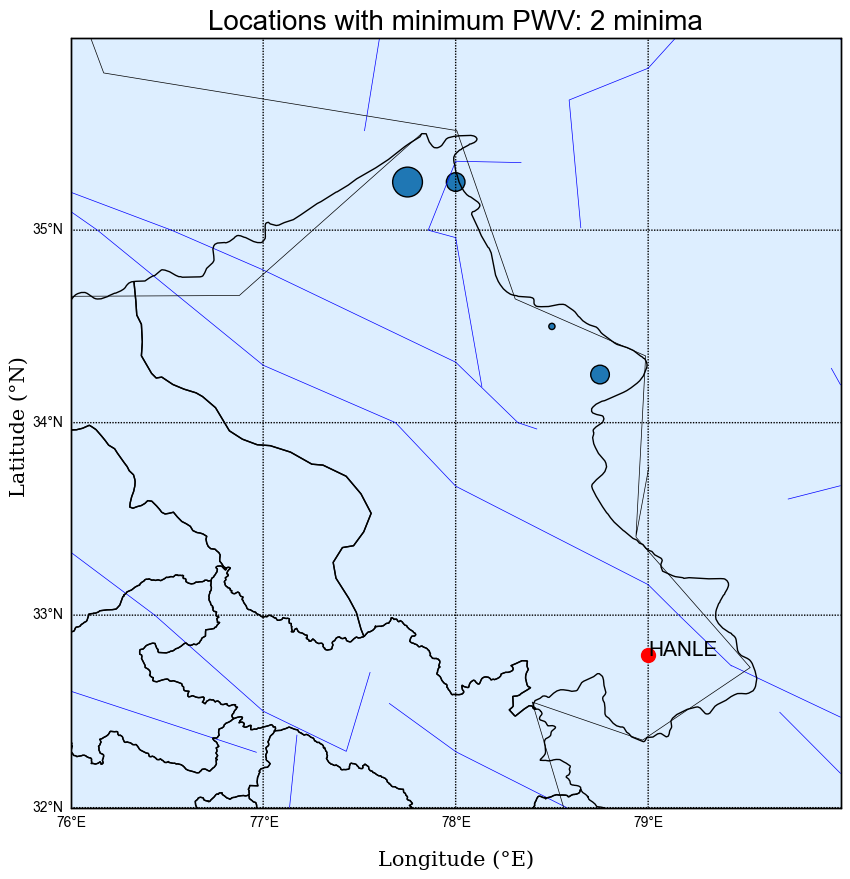

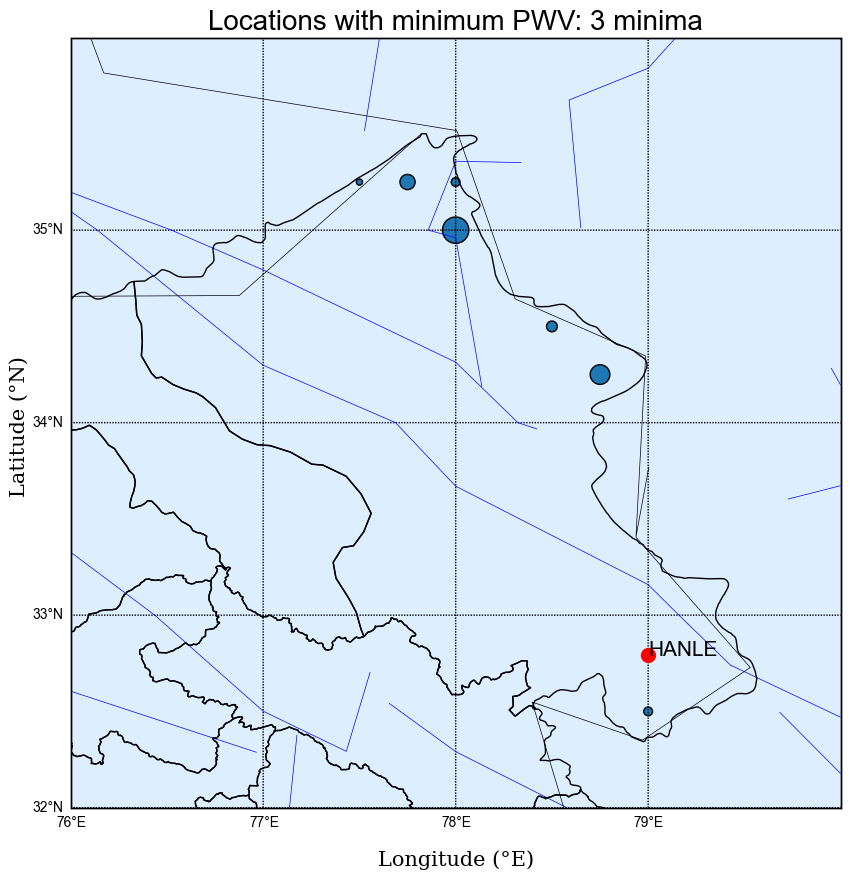

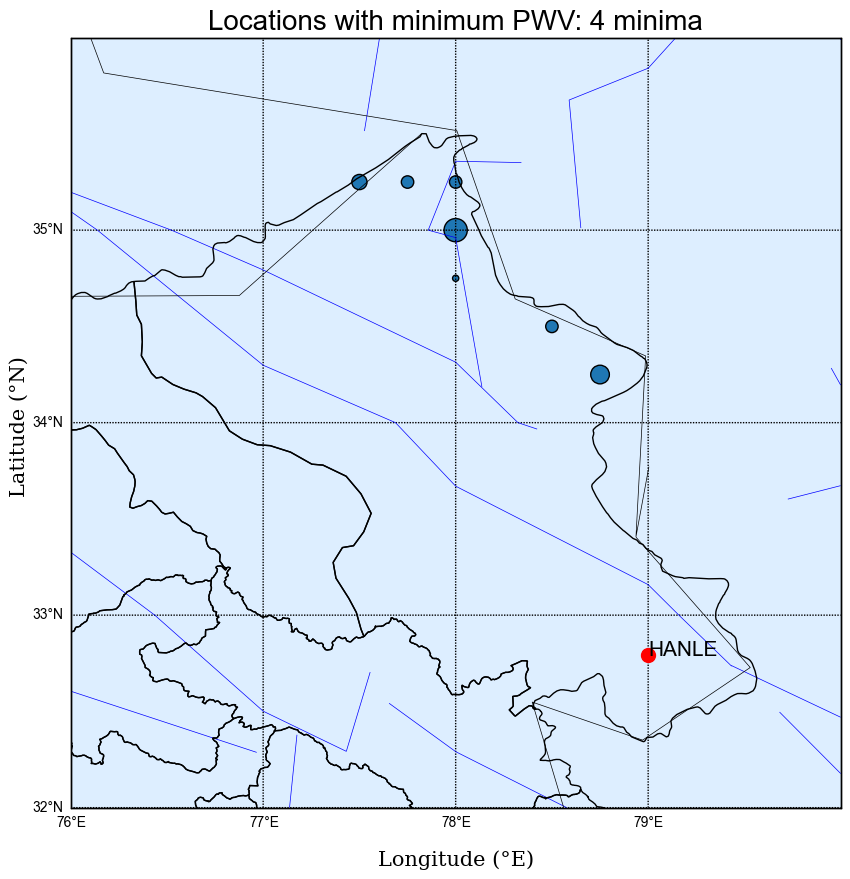

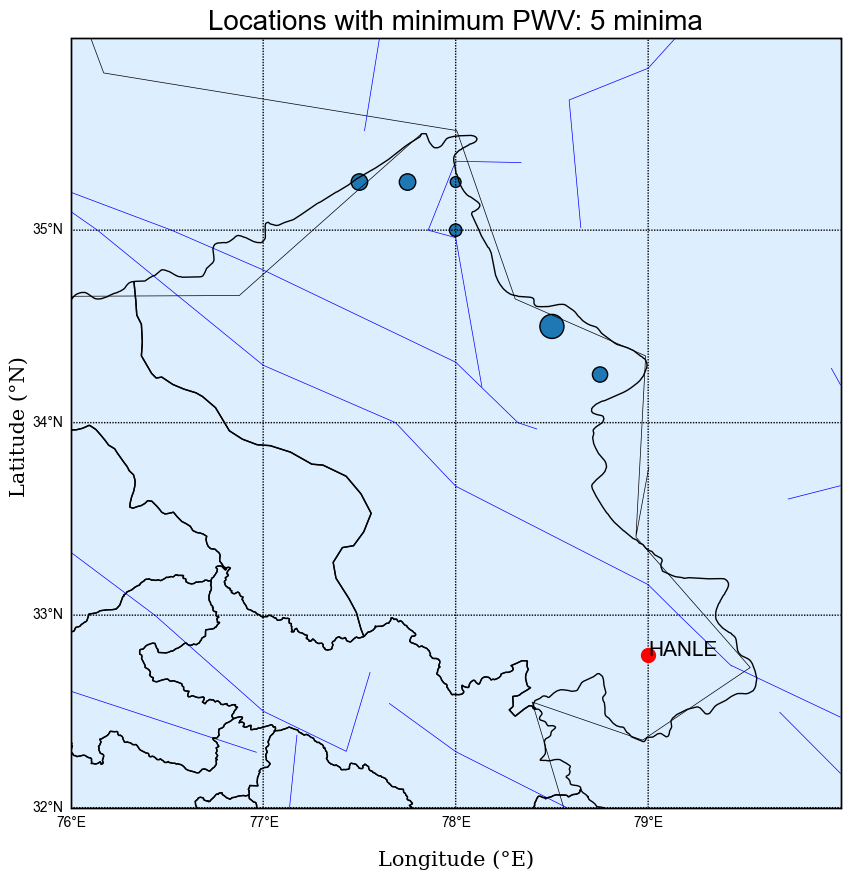

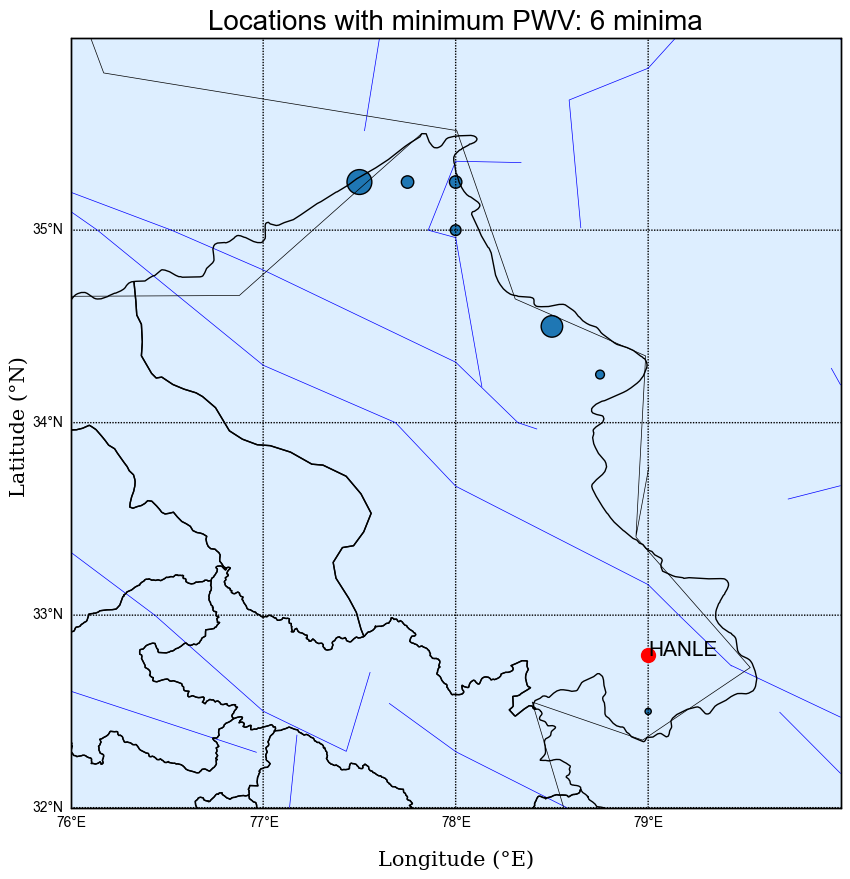

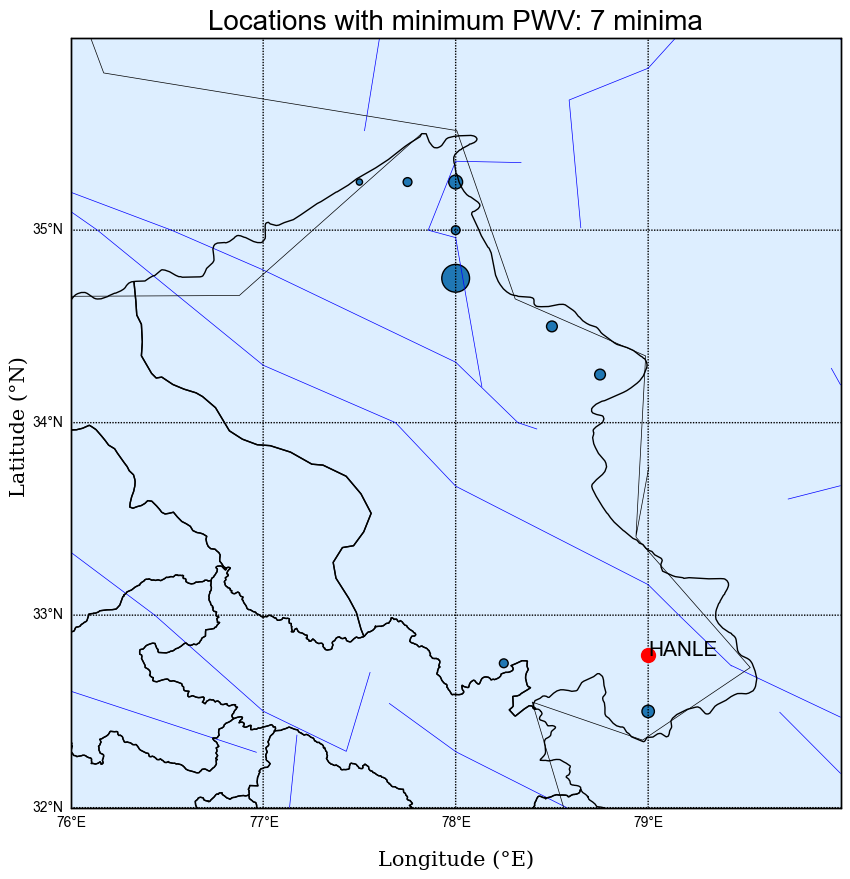

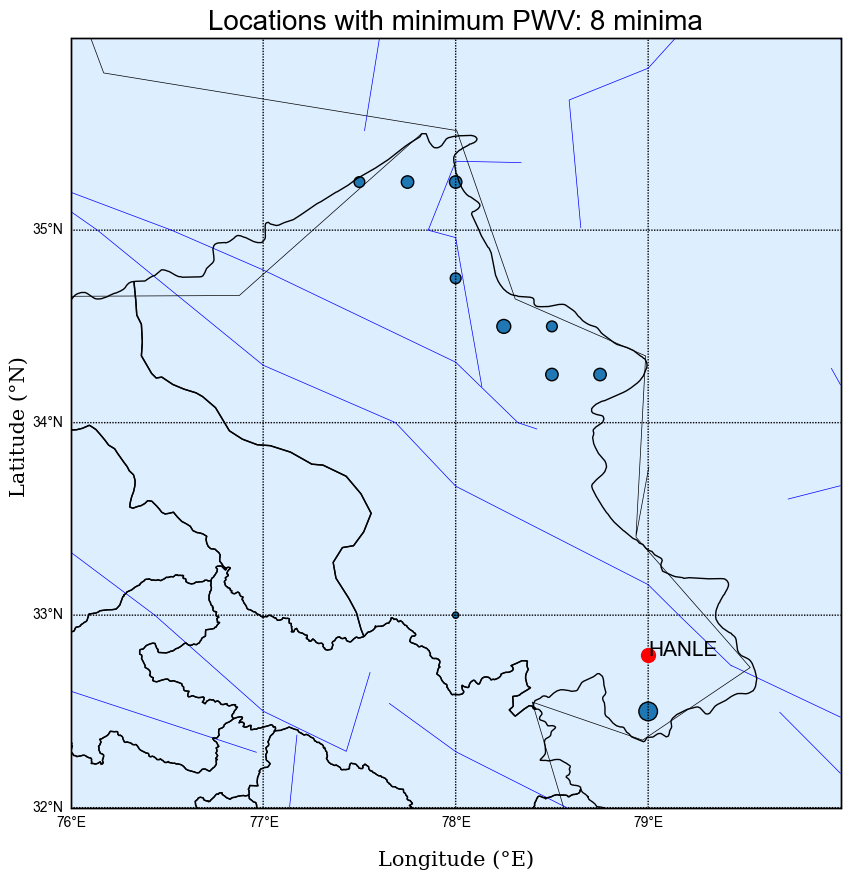

In [36]:

files = glob.glob("*.txt")
files = files[1:-1]
print(files)
for file in files:
    file_name = Path(file).stem
    file_number = file_name.split('_')[2]
    print(file_number)
    plot_locations(file,c = file_number)


In [9]:

# pwv_data = np.array(fh['tcwv'])
# print(pwv_data.shape)
# pwv_data = np.sort(pwv_data,axis=0)

# print(pwv_data[0][0])
# print(np.nanmin(pwv_data))

# no_of_points = 10
# for i in range(no_of_points):
#     np.set_printoptions(suppress=True)
#     min_val = np.nanmin(pwv_data)
#     coord = np.unravel_index(np.nanargmin(data),data.shape)
#     pwv_data[month][coord[0]][coord[1]] = np.nan

# min_val = np.nanmin(pwv_data)
# coord = np.unravel_index(np.nanargmin(pwv_data),data.shape)
# print(coord)
# # 
# # min_arr =[]
# # for i in range(no_of_points):
    
# #     for month in range(504):
# #         np.set_printoptions(suppress=True)
# #         data = pwv_data[month]
# #         min_val = np.nanmin(data)
# #         coord = np.unravel_index(np.nanargmin(data),data.shape)
# #         pwv_data[month][coord[0]][coord[1]] = np.nan
# #     min_arr.append([month+1,min_val,lats[coord[0]],lons[coord[1]]])
        

# # np.savetxt('abs_min_upto'+str(no_of_points)+'points'+'.txt',min_arr,fmt='%f %f %f %f')


In [9]:
i=0
yearly_data = []
while(i<504):
    pwv_slice = fh['tcwv'][i:i+12]
    yearly_data.append(np.array(pwv_slice))

    i+=12
yearly_data = np.array(yearly_data)
print(yearly_data.shape)

(42, 12, 14, 15)


In [10]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [11]:
def fetch_pwv_details(lat,lon,start_year = 1980,end_year = 2021):
    
    lat_idx = find_nearest(lats,lat)
    lon_idx = find_nearest(lons,lon)
    
    pwv_data_pixel = yearly_data[start_year-1980:end_year-1980+1,:,lat_idx,lon_idx]
    pwv_data_pixel = np.array(pwv_data_pixel)
    
    return np.array(np.array(pwv_data_pixel))

    

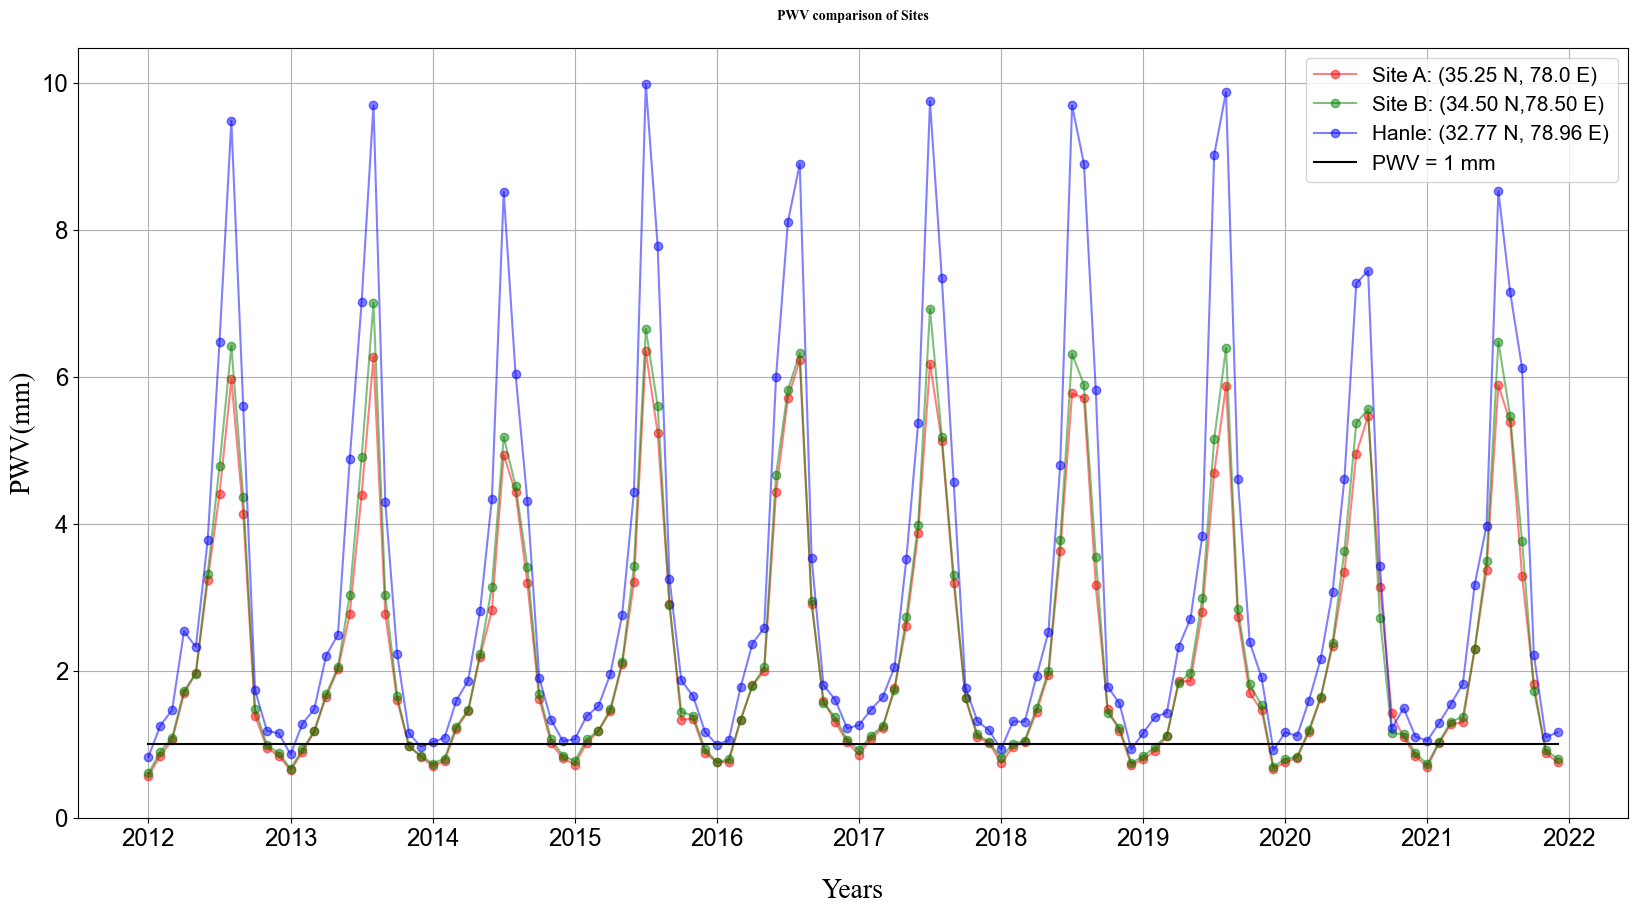

In [15]:
def plot_pwv_for_loc(lat, lon, start_year=1980, end_year=2021):
    plt.rcParams.update({'text.usetex': False})
    #plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

    #plt.rcParams['axes.labelsize'] = 20
    #plt.rcParams['font.family'] = 'sans-serif'
    #plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.figure(figsize=(20, 10))
    pwv_data_pixel = fetch_pwv_details(lat, lon, start_year, end_year)
    pwv_data_pixel = np.reshape(pwv_data_pixel, (end_year - start_year + 1) * 12)
    pwv_data_pixel_hanle = fetch_pwv_details(32.77, 78.96, start_year, end_year)
    pwv_data_pixel_hanle = np.reshape(pwv_data_pixel_hanle, (end_year - start_year + 1) * 12)
    pwv_data_pixel_other = fetch_pwv_details(34.5, 78.5, start_year, end_year)
    pwv_data_pixel_other = np.reshape(pwv_data_pixel_other, (end_year - start_year + 1) * 12)
    time = []
    for i in range(start_year, end_year + 1):
        for j in range(12):
            time.append(i + j / 12)
    time = np.array(time)
    total_months = np.sum(calc_total_below_threshold(lat, lon, threshold=1, start_year=start_year, end_year=end_year)[:, 1])
    median_months = np.nanmedian(calc_total_below_threshold(lat, lon, threshold=1, start_year=start_year, end_year=end_year)[:, 1])

    plt.grid()
    
    plt.xticks(np.arange(min(time), max(time) + 1, 1), size='xx-large')
    plt.yticks(np.arange(0, max(pwv_data_pixel_hanle) + 1, 2), size='xx-large')
    plt.xlabel("Years", size=20, font='Times New Roman', labelpad=20)
    plt.ylabel("PWV(mm)", size=20, font='Times New Roman')
    plt.title("PWV comparison of Sites", size=30, pad=20, font='Times New Roman', fontweight='bold')

    plt.plot(time, pwv_data_pixel, color='red', label='Better Site:(35.25 N, 78.00 E)', marker='o', alpha=0.5)
    plt.plot(time, pwv_data_pixel_other, color='green', label='Other: (34.50 N,78.50 E)', marker='o', alpha=0.5)
    plt.plot(time, pwv_data_pixel_hanle, color='blue', label='Hanle: (32.79 N, 79.02 E )', marker='o', alpha=0.5)
    plt.plot(time, [1] * len(time), color='black', label='PWV')

    plt.ylim(0, max(pwv_data_pixel_hanle) + 0.5)
    plt.legend(["Site A: (35.25 N, 78.0 E)", "Site B: (34.50 N,78.50 E)", "Hanle: (32.77 N, 78.96 E)", "PWV = 1 mm"], fontsize=15)
    # plt.savefig("comparison.jpeg", dpi=400)
    plt.show()

plot_pwv_for_loc(35.250, 78.0, start_year=2012, end_year=2021)


In [16]:
def calc_total_below_threshold(lat,lon,threshold,start_year=1980,end_year=2021):
    pwv_data_pixel = fetch_pwv_details(lat,lon,start_year,end_year)
    
    total_count = []
    for i in range(end_year-start_year+1):
        count = 0
        for j in range(12):
            if pwv_data_pixel[i][j] < threshold:
                count = count + 1
    
        total_count.append([start_year+i,count])
        
    return (np.array(total_count))
a = calc_total_below_threshold(34.25,  78.75 ,1,start_year=1980,end_year=2021)
print(np.sum(a[:,1]))
print(np.median(a[:,1]))
b = calc_total_below_threshold(32.7908, 79.0002,threshold=1,start_year=1980,end_year=2021)
print(np.sum(b[:,1]))
print(np.median(b[:,1]))


135
3.0
33
1.0


In [17]:
def get_all_points(threshold,start_year,end_year):

    data_all_points = []
    for i in range(14):
        for j in range(15):
            pwv_data_pixel = fetch_pwv_details(lats[i],lons[j],start_year,end_year)
            pwv_data_pixel = np.reshape(pwv_data_pixel,(end_year-start_year+1)*12)
            
            count = 0    
            for k in pwv_data_pixel:
                if k < threshold:
                    count+=1

            data_all_points.append([lats[i],lons[j],count])

    return(np.array(data_all_points))


In [18]:
all_data_points = get_all_points(1,1980,2021)
all_data_points = all_data_points[all_data_points[:,2]>0]
print(all_data_points[all_data_points[:, 2].argsort()])


[[ 32.    78.25   1.  ]
 [ 33.75  76.75   1.  ]
 [ 32.25  77.5    1.  ]
 [ 32.    78.5    1.  ]
 [ 32.75  77.     1.  ]
 [ 34.75  77.25   2.  ]
 [ 34.75  76.75   2.  ]
 [ 33.75  77.75   2.  ]
 [ 33.75  77.     3.  ]
 [ 33.    76.75   4.  ]
 [ 33.75  77.5    4.  ]
 [ 34.5   77.25   4.  ]
 [ 34.5   77.5    4.  ]
 [ 33.75  77.25   4.  ]
 [ 34.75  77.5    5.  ]
 [ 33.5   76.75   5.  ]
 [ 34.5   77.     5.  ]
 [ 32.    78.     6.  ]
 [ 34.    76.25   7.  ]
 [ 34.    78.     7.  ]
 [ 34.75  77.     7.  ]
 [ 33.    78.75   9.  ]
 [ 33.25  76.75   9.  ]
 [ 33.75  76.25   9.  ]
 [ 33.5   76.5    9.  ]
 [ 33.    79.    10.  ]
 [ 32.75  77.25  12.  ]
 [ 32.    78.75  13.  ]
 [ 34.    76.5   13.  ]
 [ 34.5   77.75  13.  ]
 [ 33.25  77.5   13.  ]
 [ 33.    79.25  14.  ]
 [ 34.25  78.    15.  ]
 [ 33.5   77.25  16.  ]
 [ 35.    77.25  16.  ]
 [ 33.5   77.    18.  ]
 [ 33.5   77.75  18.  ]
 [ 33.25  77.25  19.  ]
 [ 32.75  78.75  19.  ]
 [ 33.25  77.75  20.  ]
 [ 33.75  78.75  21.  ]
 [ 33.75  76.5  

In [19]:
sites =np.array([[35.25,77.5,107],
 [35,78,117],
 [34.5,78.5,119],
 [35.25,77.75,127],
 [35.25,78,133],
 [34.25,78.75,135]])



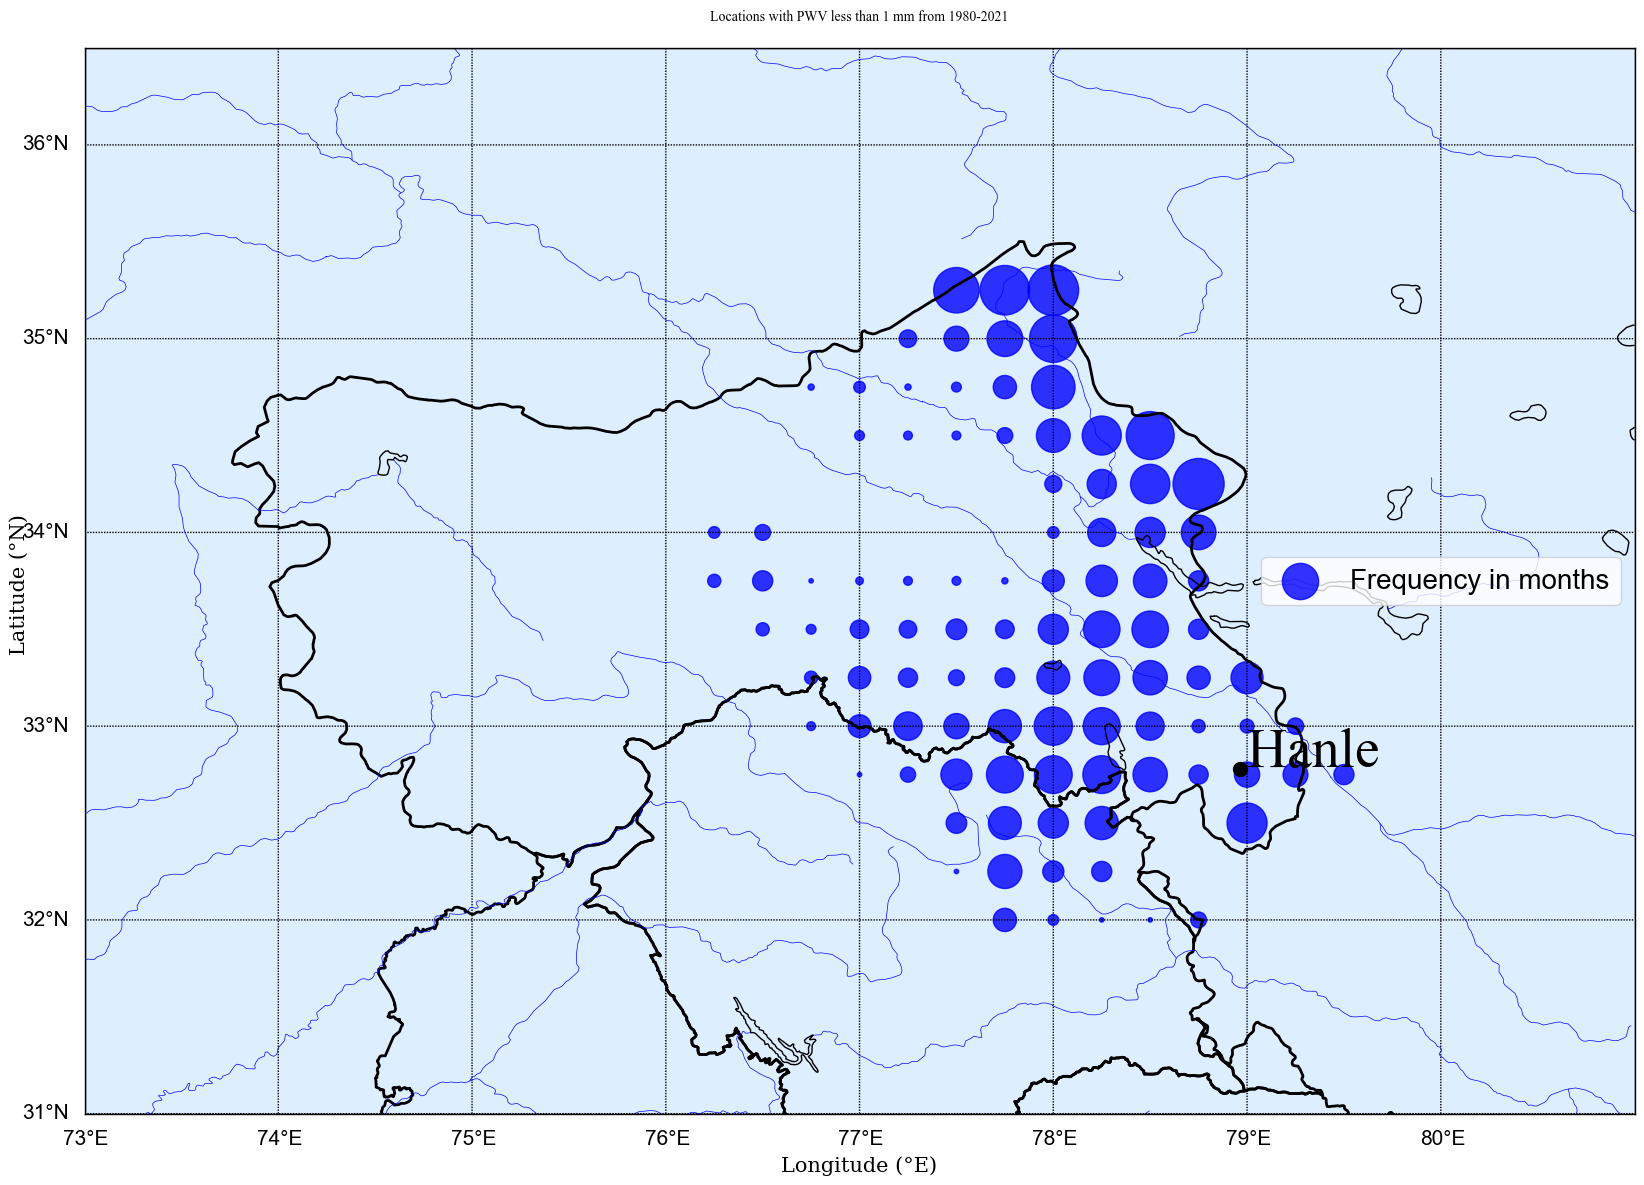

In [23]:
fontdict={'fontsize': '15', 'fontweight' : '3', 'family' : 'serif', 'color' : '#000000', 'horizontalalignment' : 'center'}


plt.figure(figsize = (20,20))

m = Basemap(
            llcrnrlat = 31,
            urcrnrlat = 36.5,
            llcrnrlon = 73,
            urcrnrlon = 81,
            resolution = 'h')
m.drawcoastlines()

m.drawparallels(np.arange(31,36.5,1),labels=[True,False,False,False],fontsize=15)
m.drawmeridians(np.arange(73,81,1),labels=[0,0,0,1],fontsize=15)
#m.drawrivers(linewidth=0.5, color='blue')
m.drawstates(linewidth=0.5, color='blue')

#c=loc_freq

sf = shp.Reader("D:\OneDrive - IIT Delhi\Intern\RRI\Shapefiles\gadm41_IND_shp\gadm41_IND_1.shp")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]

    plt.plot(x,y,color='black',linewidth=2)
    plt.xlim(xmin = 73, xmax = 81)
    plt.ylim(ymin = 31, ymax = 36.5)
plt.grid()
plt.ylabel('Latitude (°N) ',fontdict = fontdict,labelpad=40)
plt.xlabel('Longitude (°E)',fontdict = fontdict,labelpad=30)
       
m.drawstates()
m.drawmapboundary()
#m.drawmapscale()
m.drawlsmask()
m.drawrivers(color='blue',linewidth=0.5)

#m.drawcountries()
m.drawmapboundary(fill_color="#DDEEFF")
# plt.plot(78.96,32.77,  'o', color='red', markersize=10)
# plt.text(78.1,35.3, 'Site A', fontsize =20,font = 'Times New Roman')
# plt.plot(78.00,35.25,'o',color='red',markersize=10)
# plt.text(79.0002,32.7908,  'Hanle', fontsize=20,font = 'Times New Roman')
# plt.plot( 78.50,34.50,  'o', color='red', markersize=10)
# plt.text(78.50+0.1,34.50+0.1, 'Site B', fontsize =20,font = 'Times New Roman')

plt.plot( 78.9651,32.7789,'o',color='black',markersize=10)
plt.text(79.0002,32.7908,  'Hanle', fontsize=40,font = 'Times New Roman')
plt.scatter(all_data_points[:,1],all_data_points[:,0],s=all_data_points[:,2]*10,color='blue',alpha=0.8,label ='Frequency in months')
plt.legend(fontsize = 20)
plt.title('Locations with PWV less than 1 mm from 1980-2021', fontsize=30,font = 'Times New Roman',pad = '20')

#plt.savefig('all_locations_map.jpeg',dpi=400,bbox_inches='tight')
plt.show()